# %% [markdown]

 # EDA

# %% [markdown]

 ## Import Libraries

In [1]:
import copy
from pathlib import Path
from typing import Optional

import torch
from braindecode.datasets import BaseConcatDataset
from braindecode.models import EEGNeX
from braindecode.preprocessing import (
    Preprocessor,
    create_windows_from_events,
    preprocess,
)
from eegdash.dataset import EEGChallengeDataset
from eegdash.hbn.windows import (
    add_aux_anchors,
    add_extras_columns,
    annotate_trials_with_target,
    keep_only_recordings_with,
)
from joblib import Parallel, delayed
from matplotlib.pylab import plt
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from torch.nn import Module
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader
from tqdm.auto import tqdm

# %% [markdown]

 ## Constants

In [2]:
MINI_DATASET_ROOT = Path("/media/varun/braininahat/datasets/eeg2025/mini/")
EPOCH_LEN_S = 2.0
SFREQ = 100
ANCHOR = "stimulus_anchor"
SHIFT_AFTER_STIM = 0.5
WINDOW_LEN = 2.0

# Validation and test set fractions
VALID_FRAC = 0.1
TEST_FRAC = 0.1
# Random seed
SEED = 2025

SUBJECTS_TO_REMOVE = [
    "NDARWV769JM7",
    "NDARME789TD2",
    "NDARUA442ZVF",
    "NDARJP304NK1",
    "NDARTY128YLU",
    "NDARDW550GU6",
    "NDARLD243KRE",
    "NDARUJ292JXV",
    "NDARBA381JGH",
]

BATCH_SIZE = 128
NUM_WORKERS = 8

LR = 1e-3
WEIGHT_DECAY = 1e-5
N_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 50

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# %% [markdown]

 ## Load Data

In [3]:
dataset_ccd = EEGChallengeDataset(
    task="contrastChangeDetection",
    release="R1",
    mini=True,
    cache_dir=MINI_DATASET_ROOT,
)

/home/varun/repos/cerebro/.venv/lib/python3.12/site-packages/eegdash/dataset/dataset.py:126: UserWarning: 

[EEGChallengeDataset] EEG 2025 Competition Data Notice:
-------------------------------------------------------
This object loads the HBN dataset that has been preprocessed for the EEG Challenge:
  - Downsampled from 500Hz to 100Hz
  - Bandpass filtered (0.5–50 Hz)

For full preprocessing details, see:
  https://github.com/eeg2025/downsample-datasets

IMPORTANT: The data accessed via `EEGChallengeDataset` is NOT identical to what you get from `EEGDashDataset` directly.
If you are participating in the competition, always use `EEGChallengeDataset` to ensure consistency with the challenge data.


  warn(


# %% [markdown]

 ## Explore Data

Using matplotlib as 2D backend.


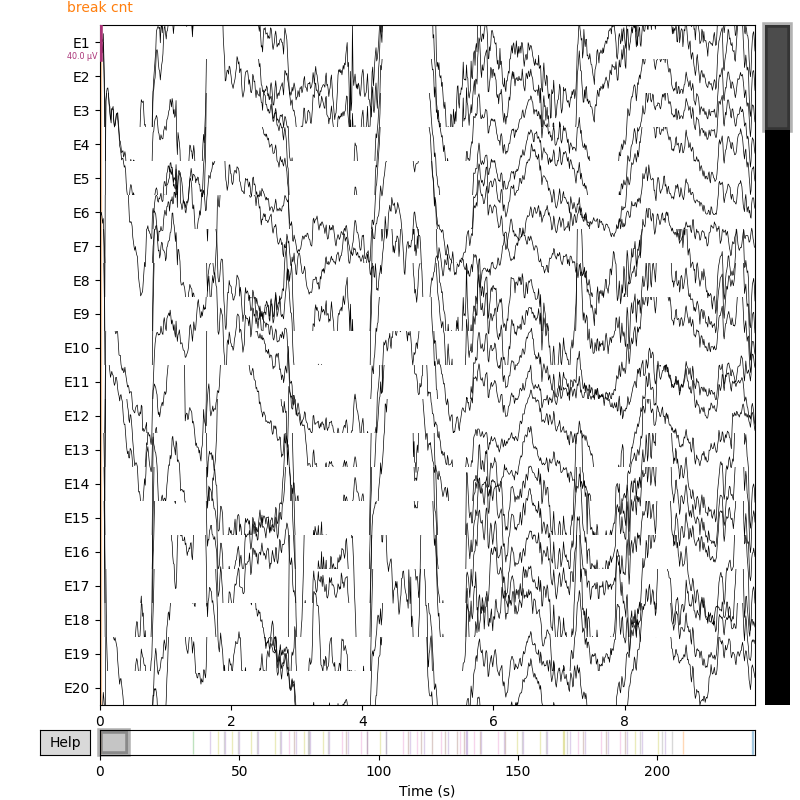

In [4]:
# %%

%matplotlib widget

raw = dataset_ccd.datasets[0].raw

fig = raw.plot()

# %% [markdown]

 ## Download all

In [5]:
# %%
%matplotlib inline
raws = Parallel(n_jobs=-1)(delayed(lambda d: d.raw)(d) for d in dataset_ccd.datasets)

# %% [markdown]

 ## Braindecode init

# %% [markdown]

 ## Epoching

In [6]:
# %%

transformation_offline = [
    Preprocessor(
        annotate_trials_with_target,
        target_field="rt_from_stimulus",
        epoch_length=EPOCH_LEN_S,
        require_stimulus=True,
        require_response=True,
        apply_on_array=False,
    ),
    Preprocessor(add_aux_anchors, apply_on_array=False),
]
preprocess(dataset_ccd, transformation_offline, n_jobs=1)

/home/varun/repos/cerebro/.venv/lib/python3.12/site-packages/eegdash/hbn/windows.py:165: RuntimeWarning: Omitted 11 annotation(s) that were outside data range.
  raw.set_annotations(new_ann, verbose=False)
/home/varun/repos/cerebro/.venv/lib/python3.12/site-packages/eegdash/hbn/windows.py:216: RuntimeWarning: Omitted 2 annotation(s) that were outside data range.
  raw.set_annotations(ann + aux, verbose=False)


# %% [markdown]

 ## Filter for stimulus anchor presence

In [7]:
# %%

dataset = keep_only_recordings_with(ANCHOR, dataset_ccd)

# %% [markdown]

 ## Window creation

In [8]:
# %%

single_windows = create_windows_from_events(
    dataset,
    mapping={ANCHOR: 0},
    trial_start_offset_samples=int(SHIFT_AFTER_STIM * SFREQ),
    trial_stop_offset_samples=int((SHIFT_AFTER_STIM + WINDOW_LEN) * SFREQ),
    window_size_samples=int(EPOCH_LEN_S * SFREQ),
    window_stride_samples=SFREQ,
    preload=True,
)

Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_('stimulus_anchor')]
Used Annotations descriptions: [np.str_(

# %% [markdown]

 ## Add metadata

In [9]:
# %%

single_windows = add_extras_columns(
    single_windows,
    dataset,
    desc=ANCHOR,
    keys=(
        "target",
        "rt_from_stimulus",
        "rt_from_trialstart",
        "stimulus_onset",
        "response_onset",
        "correct",
        "response_type",
    ),
)

# %% [markdown]

 ## Inspect metadata

In [10]:
# %%

single_windows.get_metadata().head()

,i_window_in_trial,i_start_in_trial,i_stop_in_trial,target,rt_from_stimulus,rt_from_trialstart,stimulus_onset,response_onset,correct,response_type,...,thepresent,diaryofawimpykid,contrastchangedetection_1,contrastchangedetection_2,contrastchangedetection_3,surroundsupp_1,surroundsupp_2,seqlearning6target,seqlearning8target,symbolsearch
0,0,4278,4478,2.13,2.13,4.93,42.284,44.414,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
1,0,4798,4998,1.96,1.96,4.76,47.484,49.444,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
2,0,5478,5678,2.02,2.02,6.42,54.284,56.304,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
3,0,6318,6518,1.72,1.72,7.72,62.684,64.404,1,right_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available
4,0,6838,7038,1.8,1.8,4.6,67.884,69.684,1,left_buttonPress,...,available,available,available,available,available,available,available,unavailable,available,available


# %% [markdown]

 ## Target inspection

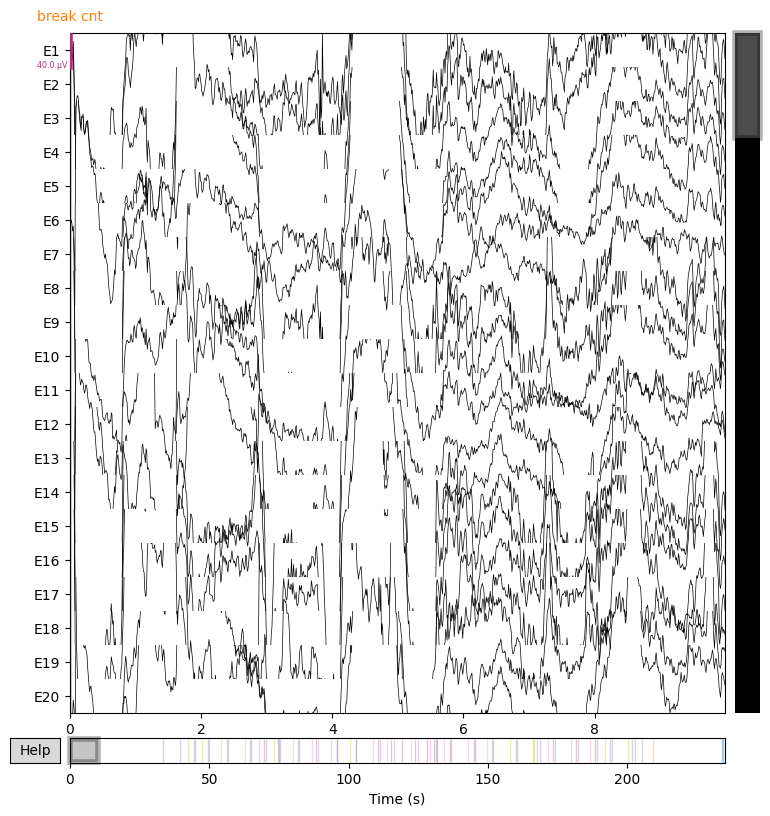

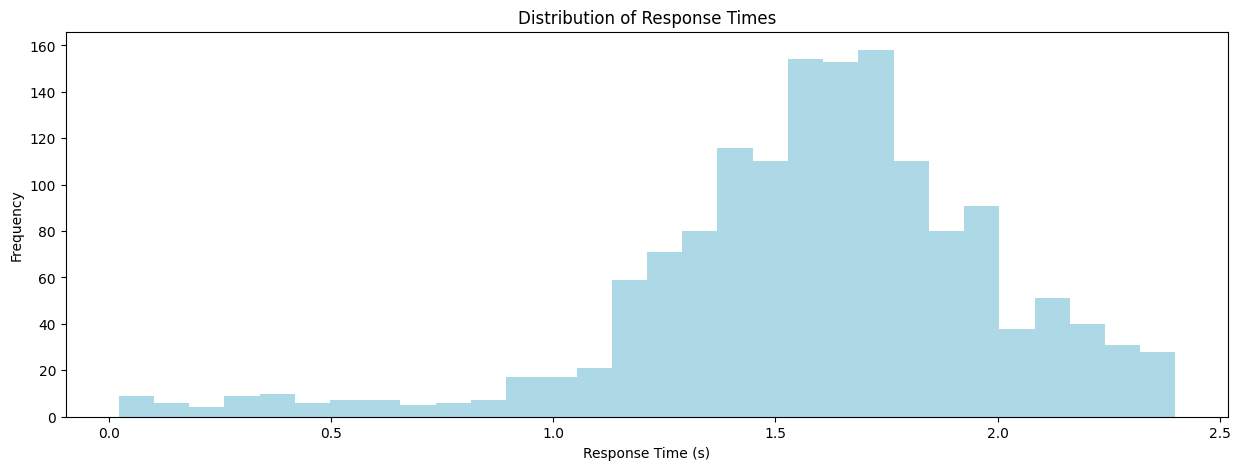

In [11]:
% matplotlib widget

fig, ax = plt.subplots(figsize=(15, 5))
ax = single_windows.get_metadata()["target"].plot.hist(
    bins=30, ax=ax, color="lightblue"
)
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Response Times")
plt.show()

# %% [markdown]

 ## Train Test Split (Stratified by subject)

In [12]:
# %%

subjects = single_windows.description["subject"].unique()
print(f"Number of subjects: {len(subjects)}")
print(f"Subjects: {subjects}")

Number of subjects: 20
Subjects: ['NDARAC904DMU' 'NDARAM704GKZ' 'NDARAP359UM6' 'NDARBD879MBX'
 'NDARBH024NH2' 'NDARBK082PDD' 'NDARCA153NKE' 'NDARCE721YB5'
 'NDARCJ594BWQ' 'NDARCN669XPR' 'NDARCW094JCG' 'NDARCZ947WU5'
 'NDARDH670PXH' 'NDARDL511UND' 'NDARDU986RBM' 'NDAREM731BYM'
 'NDAREN519BLJ' 'NDARFK610GY5' 'NDARFT581ZW5' 'NDARFW972KFQ']


# %% [markdown]

 ## Remove subjects

In [13]:
# %%

subjects = [s for s in subjects if s not in SUBJECTS_TO_REMOVE]
print(f"Number of subjects: {len(subjects)}")
print(f"Subjects: {subjects}")

Number of subjects: 20
Subjects: ['NDARAC904DMU', 'NDARAM704GKZ', 'NDARAP359UM6', 'NDARBD879MBX', 'NDARBH024NH2', 'NDARBK082PDD', 'NDARCA153NKE', 'NDARCE721YB5', 'NDARCJ594BWQ', 'NDARCN669XPR', 'NDARCW094JCG', 'NDARCZ947WU5', 'NDARDH670PXH', 'NDARDL511UND', 'NDARDU986RBM', 'NDAREM731BYM', 'NDAREN519BLJ', 'NDARFK610GY5', 'NDARFT581ZW5', 'NDARFW972KFQ']


# %% [markdown]

 ## Train Test Split

In [14]:
# %%

train_subj, valid_test_subject = train_test_split(
    subjects,
    test_size=(VALID_FRAC + TEST_FRAC),
    random_state=check_random_state(SEED),
    shuffle=True,
)

valid_subj, test_subj = train_test_split(
    valid_test_subject,
    test_size=TEST_FRAC,
    random_state=check_random_state(SEED + 1),
    shuffle=True,
)

# %% [markdown]

 ## Sanity check

In [15]:
# %%

assert (set(valid_subj) | set(test_subj) | set(train_subj)) == set(subjects)

# %% [markdown]

 ## Create train/valid/test splits for the windows

In [16]:
# %%

subject_split = single_windows.split("subject")
train_set = []
valid_set = []
test_set = []

for s in subject_split:
    if s in train_subj:
        train_set.append(subject_split[s])
    elif s in valid_subj:
        valid_set.append(subject_split[s])
    elif s in test_subj:
        test_set.append(subject_split[s])

train_set = BaseConcatDataset(train_set)
valid_set = BaseConcatDataset(valid_set)
test_set = BaseConcatDataset(test_set)

# %% [markdown]

 ## Create dataloaders

In [17]:
# %%

train_loader = DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)
valid_loader = DataLoader(
    valid_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)
test_loader = DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

# %% [markdown]

 ## Build the model

In [18]:
# %%

model = EEGNeX(n_chans=129, n_outputs=1, n_times=2 * SFREQ, sfreq=SFREQ)

# %% [markdown]

 ## Print model

In [19]:
# %%

print(model)

Layer (type (var_name):depth-idx)                            Input Shape               Output Shape              Param #                   Kernel Shape
EEGNeX (EEGNeX)                                              [1, 129, 200]             [1, 1]                    --                        --
├─Sequential (block_1): 1-1                                  [1, 129, 200]             [1, 8, 129, 200]          --                        --
│    └─Rearrange (0): 2-1                                    [1, 129, 200]             [1, 1, 129, 200]          --                        --
│    └─Conv2d (1): 2-2                                       [1, 1, 129, 200]          [1, 8, 129, 200]          512                       [1, 64]
│    └─BatchNorm2d (2): 2-3                                  [1, 8, 129, 200]          [1, 8, 129, 200]          16                        --
├─Sequential (block_2): 1-2                                  [1, 8, 129, 200]          [1, 32, 129, 200]         --                  

/home/varun/repos/cerebro/.venv/lib/python3.12/site-packages/torch/nn/modules/conv.py:543: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at /pytorch/aten/src/ATen/native/Convolution.cpp:1027.)
  return F.conv2d(


# %% [markdown]

 ## Train the model

# %% [markdown]

 ## Define training functions

In [20]:
# %%

def train_one_epoch(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    optimizer,
    scheduler: Optional[LRScheduler],
    epoch: int,
    device,
    print_batch_stats: bool = True,
):
    model.train()

    total_loss = 0.0
    sum_sq_err = 0.0
    n_samples = 0

    progress_bar = tqdm(
        enumerate(dataloader), total=len(dataloader), disable=not print_batch_stats
    )

    for batch_idx, batch in progress_bar:
        # Support datasets that may return (X, y) or (X, y, ...)
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()

        optimizer.zero_grad(set_to_none=True)
        preds = model(X)
        loss = loss_fn(preds, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Flatten to 1D for regression metrics and accumulate squared error
        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            progress_bar.set_description(
                f"Epoch {epoch}, Batch {batch_idx + 1}/{len(dataloader)}, "
                f"Loss: {loss.item():.6f}, RMSE: {running_rmse:.6f}"
            )

    if scheduler is not None:
        scheduler.step()

    avg_loss = total_loss / len(dataloader)
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
    return avg_loss, rmse

# %% [markdown]

 ## Define validation function

In [21]:
# %%

def valid_model(
    dataloader: DataLoader,
    model: Module,
    loss_fn,
    device,
    print_batch_stats: bool = True,
):
    model.eval()
    total_loss = 0.0
    sum_sq_err = 0.0
    n_batches = len(dataloader)
    n_samples = 0

    iterator = tqdm(
        enumerate(dataloader), total=n_batches, disable=not print_batch_stats
    )

    for batch_idx, batch in iterator:
        # Supports (X, y) or (X, y, ...)\n",
        X, y = batch[0], batch[1]
        X, y = X.to(device).float(), y.to(device).float()

        preds = model(X)
        batch_loss = loss_fn(preds, y).item()
        total_loss += batch_loss

        preds_flat = preds.detach().view(-1)
        y_flat = y.detach().view(-1)
        sum_sq_err += torch.sum((preds_flat - y_flat) ** 2).item()
        n_samples += y_flat.numel()

        if print_batch_stats:
            running_rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5
            iterator.set_description(
                f"Val Batch {batch_idx + 1}/{n_batches}, "
                f"Loss: {batch_loss:.6f}, RMSE: {running_rmse:.6f}"
            )

    avg_loss = total_loss / n_batches if n_batches else float("nan")
    rmse = (sum_sq_err / max(n_samples, 1)) ** 0.5

    print(f"Val RMSE: {rmse:.6f}, Val Loss: {avg_loss:.6f}\n")
    return avg_loss, rmse

# %% [markdown]

 ## Train the model

In [22]:
# %%

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=N_EPOCHS - 1)
loss_fn = torch.nn.MSELoss()

patience = EARLY_STOPPING_PATIENCE
min_delta = 1e-4
best_rmse = float("inf")
epochs_no_improve = 0
best_state, best_epoch = None, None

# %% [markdown]

 ## Train the model

In [ ]:
# %%

for epoch in range(1, N_EPOCHS + 1):
    print(f"Epoch {epoch}/{N_EPOCHS}: ", end="")

    train_loss, train_rmse = train_one_epoch(
        train_loader, model, loss_fn, optimizer, scheduler, epoch, DEVICE
    )
    val_loss, val_rmse = valid_model(test_loader, model, loss_fn, DEVICE)

    print(
        f"Train RMSE: {train_rmse:.6f}, Average Train Loss: {train_loss:.6f}, Val RMSE: {val_rmse:.6f}, Average Val Loss: {val_loss:.6f}"
    )

    if val_rmse < best_rmse - min_delta:
        best_rmse = val_rmse
        best_state = copy.deepcopy(model.state_dict())
        best_epoch = epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(
                f"Early stopping at epoch {epoch}. Best Val RMSE: {best_rmse:.6f} (epoch {best_epoch})"
            )
            break

Epoch 1/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 1.560767, Val Loss: 2.435994

Train RMSE: 1.456841, Average Train Loss: 2.063644, Val RMSE: 1.560767, Average Val Loss: 2.435994
Epoch 2/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 1.215484, Val Loss: 1.477401

Train RMSE: 1.118416, Average Train Loss: 1.185928, Val RMSE: 1.215484, Average Val Loss: 1.477401
Epoch 3/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.384578, Val Loss: 0.147900

Train RMSE: 0.637710, Average Train Loss: 0.405524, Val RMSE: 0.384578, Average Val Loss: 0.147900
Epoch 4/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.390952, Val Loss: 0.152843

Train RMSE: 0.560507, Average Train Loss: 0.319362, Val RMSE: 0.390952, Average Val Loss: 0.152843
Epoch 5/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.461136, Val Loss: 0.212647

Train RMSE: 0.548729, Average Train Loss: 0.292813, Val RMSE: 0.461136, Average Val Loss: 0.212647
Epoch 6/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.413321, Val Loss: 0.170835

Train RMSE: 0.514149, Average Train Loss: 0.268654, Val RMSE: 0.413321, Average Val Loss: 0.170835
Epoch 7/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.408071, Val Loss: 0.166522

Train RMSE: 0.519843, Average Train Loss: 0.259788, Val RMSE: 0.408071, Average Val Loss: 0.166522
Epoch 8/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.413914, Val Loss: 0.171325

Train RMSE: 0.512023, Average Train Loss: 0.258409, Val RMSE: 0.413914, Average Val Loss: 0.171325
Epoch 9/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.433736, Val Loss: 0.188126

Train RMSE: 0.495204, Average Train Loss: 0.249643, Val RMSE: 0.433736, Average Val Loss: 0.188126
Epoch 10/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.410796, Val Loss: 0.168753

Train RMSE: 0.504231, Average Train Loss: 0.248924, Val RMSE: 0.410796, Average Val Loss: 0.168753
Epoch 11/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.436012, Val Loss: 0.190106

Train RMSE: 0.491954, Average Train Loss: 0.236451, Val RMSE: 0.436012, Average Val Loss: 0.190106
Epoch 12/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.445729, Val Loss: 0.198674

Train RMSE: 0.488534, Average Train Loss: 0.247802, Val RMSE: 0.445729, Average Val Loss: 0.198674
Epoch 13/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.417580, Val Loss: 0.174373

Train RMSE: 0.500870, Average Train Loss: 0.245767, Val RMSE: 0.417580, Average Val Loss: 0.174373
Epoch 14/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Val RMSE: 0.413538, Val Loss: 0.171014

Train RMSE: 0.488909, Average Train Loss: 0.237396, Val RMSE: 0.413538, Average Val Loss: 0.171014
Epoch 15/100: 

  0%|          | 0/10 [00:00<?, ?it/s]

# %% [markdown]

 ## Save the model

In [ ]:
# %%

from pathlib import Path
weights_dir = Path("weights")
weights_dir.mkdir(exist_ok=True)
torch.save(model.state_dict(), weights_dir / "weights_challenge_1.pt")
print("Model saved as 'weights/weights_challenge_1.pt'")